# [IAFlash](https://entrepreneur-interet-general.etalab.gouv.fr/defis/2019/iaflash.html) simple exploration

## Exemple of clustering images

Clusturing images may be useful to label a dataset of unlabel data: first cluster the data, then use the cluster as label. Optionally, find a small amount of label data to project onto the clusters, in order to infer the true of label corresponding to each cluster.  
We follow this [tutorial](https://www.pyimagesearch.com/2018/07/09/face-clustering-with-python/).

### Imports

In [1]:
import os
HOME = os.path.expanduser('~/')
HOST = os.uname()[1]
if HOST == 'Arthurs-MacBook-Pro.local':
    os.chdir(os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/'))    # @home
else:
    raise ValueError('unknown host: {}'.format(HOST))
    
import numpy as np
import re
import time
import pickle
from PIL import Image

from skimage.feature import daisy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

from IAFlash.basehelpers import pcaPlot

### Variables

In [2]:
# data
if HOST == 'Arthurs-MacBook-Pro.local':
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwFalseresampleFilter0') # (small) MobileNet
#     pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge128bwTrueresampleFilter0') # dummy model
    pathToDataDir = os.path.join(HOME, 'Documents/Dropbox/Transit/EIG3_IAFlash/Patches/edge299bwFalseresampleFilter0') # InceptionV3
    pathToIntellDir = os.path.join(HOME, 'Documents/GitHub/EIG3_IAFlash/IAFlash/Intelligence/')
else:
    raise ValueError('unknown host: {}'.format(HOST))
data_format = 'channels_last'
nbClass = 196

# image processing
edge = int(re.findall('edge([0-9]*)',pathToDataDir)[0])
if 'bwTrue' in pathToDataDir:
    mode = 'grayscale'
elif 'bwFalse' in pathToDataDir:
    mode = 'rgb'
else:
    raise ValueError('color mode not undestood from data directory name')
    
# model compilation params


# seed
seed = 8
np.random.seed(seed)

### Intelligence

We use the [`ORB`](http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.ORB) feature detector and binary descriptor extractor from [scikit-image](https://scikit-image.org).  
NB: it seems that images must be not too small.  

In [3]:
# from skimage import data
# from skimage import transform as tf
# from skimage.feature import ORB, plot_matches, match_descriptors
# import matplotlib.pyplot as plt

# n_scales = 20 # 8
# n_keypoints = 33
# fast_n = int(16/2)
# fast_threshold = 0.08 # decrease the threshold when more corners are desired and vice-versa
# harris_k = 0.04 # small values of k result in detection of sharp corners


# image_file1 = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014241.jpg')
# image_file2 = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014264.jpg')

# image1 = Image.open(image_file1)
# image2 = Image.open(image_file2)


# img1 = np.array(image1.convert('L'))
# img2 = np.array(image2.convert('L'))


# descriptor_extractor = ORB(n_keypoints=n_keypoints,
#                            downscale=1.2,
#                            n_scales=n_scales,
#                            fast_n=fast_n,
#                            fast_threshold=fast_threshold,
#                            harris_k=harris_k)

# descriptor_extractor.detect_and_extract(img1)
# keypoints1 = descriptor_extractor.keypoints
# descriptors1 = descriptor_extractor.descriptors

# descriptor_extractor.detect_and_extract(img2)
# keypoints2 = descriptor_extractor.keypoints
# descriptors2 = descriptor_extractor.descriptors

# matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

# f = plt.figure(figsize = (15,10))
# ax = f.add_subplot(1,1,1)

# plot_matches(ax, img1, img2, keypoints1, keypoints2, matches12)
# ax.axis('off')
# ax.set_title("Original Image vs. Transformed Image")

# plt.show()

Now let's test the [`daisy`](http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.daisy) descriptor.  
NB: it is not a feature extractor, that it, is does not describe 'keypoints' only, but rather all the image, as densely sampled according to parameters `step` and others.  

Pb: there may be a risk that the features described are not always insctructive!

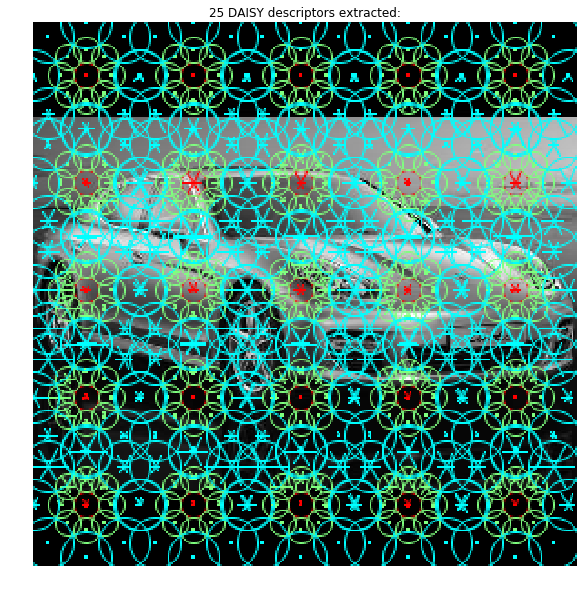

In [4]:
step = int(edge/5)
rings = 2

radius = int(step/(rings))
histograms = 8
orientations = 6
visualize = True



image_file1 = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014241.jpg')
image_file2 = os.path.join(pathToDataDir, 'Test', 'Porsche Panamera Sedan 2012/014264.jpg')

image1 = Image.open(image_file1)
image2 = Image.open(image_file2)

img1 = np.array(image1.convert('L'))
img2 = np.array(image2.convert('L'))

descs, descs_img = daisy(img1,
                         step=step,
                         radius=radius,
                         rings=rings,
                         histograms=histograms,
                         orientations=orientations, 
                         visualize=visualize)


f = plt.figure(figsize = (15,10))
ax = f.add_subplot(1,1,1)

ax.axis('off')
ax.imshow(descs_img)
descs_num = descs.shape[0] * descs.shape[1]
ax.set_title('%i DAISY descriptors extracted:' % descs_num)

plt.show()

OK let's try them for feature extraction over all our data

In [5]:
step = int(edge/5)
rings = 2

radius = int(step/(rings))
histograms = 8
orientations = 6
visualize = False
normalization = 'daisy' # L2-normalization of individual histograms
_R = (rings * histograms + 1) * orientations # number of features extracted (see docstring)

dataDir = os.path.join(pathToDataDir, 'Train')

In [ ]:
# gather together all daisy features from all images

tic = time.time()

ls_allFeat = [] # list all features to later define centroid features
ls_avgFeat = [] # store the average feature used to match against centroid features
ls_y = []       # used later

i = 0
for root,folders,files in os.walk(dataDir):
    for f in files:
        i += 1
        
        image = Image.open(os.path.join(root,f))
        x_im = np.array(image.convert('L'))

        descs = daisy(x_im,
                      step=step,
                      radius=radius,
                      rings=rings,
                      histograms=histograms,
                      orientations=orientations, 
                      visualize=visualize,
                      normalization=normalization)
        _allFeat = descs.reshape(descs.shape[0]*descs.shape[1],descs.shape[2])
        
        ls_allFeat += _allFeat.tolist()
        ls_avgFeat += [_allFeat.mean(axis=0).tolist()] # extra [] so that concatenation will happen vertically
        ls_y.append(os.path.split(root)[-1])

#     if i>100: break
        
allFeat = np.array(ls_allFeat)
avgFeat = np.array(ls_avgFeat)
_,y = np.unique(ls_y, return_inverse=True)

print('done: took {}s'.format(np.round(time.time()-tic,2)))

In [ ]:
# search for clusters in the set of daisy features
# using KMeans
n_centroidFeatures = 200

tic = time.time()

kmeans = KMeans(n_clusters=n_centroidFeatures, random_state=seed)
kmeans.fit(allFeat)

print('done: took {}s'.format(np.round(time.time()-tic,2)))

In [9]:
# (not really sensible here actually) validate graphically

pca = PCA(n_components=3,
          copy=True,
          iterated_power='auto', 
          random_state=seed,
          svd_solver='auto',
          tol=0.0,
          whiten=False)
allFeat_pc = pca.fit_transform(allFeat)

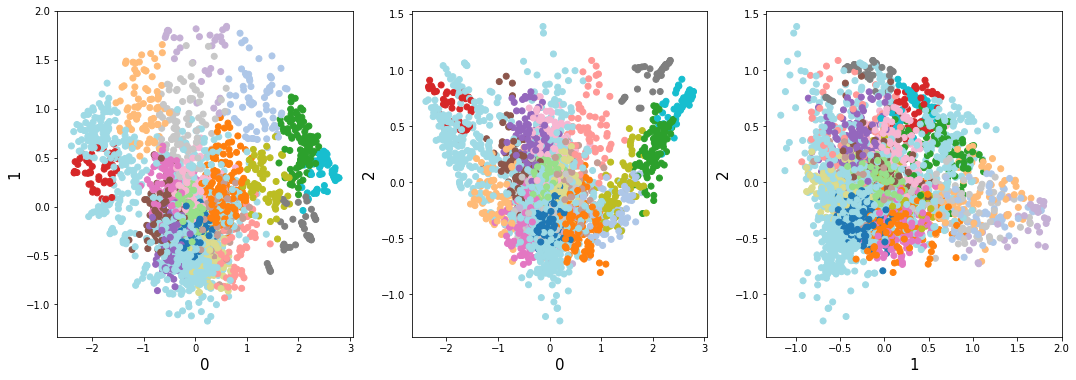

In [10]:
pcaPlot(allFeat_pc, cm.tab20(kmeans.labels_))

In [11]:
# given the 'centroid' features, now compute the bag-of-daisy vector for each image

centroidFeat = avgFeat.dot(kmeans.cluster_centers_.transpose())
centroidFeat = centroidFeat / np.sqrt(np.sum(centroidFeat**2))

In [12]:
# validate graphically

pca = PCA(n_components=3,
          copy=True,
          iterated_power='auto', 
          random_state=seed,
          svd_solver='auto',
          tol=0.0,
          whiten=False)
centroidFeat_pc = pca.fit_transform(centroidFeat)

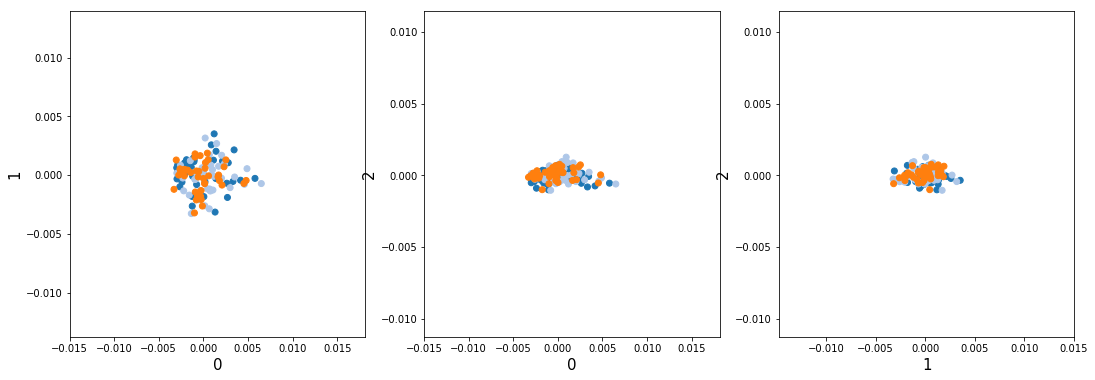

In [13]:
pcaPlot(centroidFeat_pc, cm.tab20(y))